In [1]:
from os import listdir
import pandas as pd
import numpy as np
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split
from keras.layers import Dropout
from keras.models import load_model
from keras.models import Sequential
from keras import layers
from keras import optimizers
from keras import metrics
import matplotlib.pyplot as plt
import seaborn as sns

Using TensorFlow backend.


In [2]:
## Clean up data
final = pd.DataFrame()
for file in listdir("../data"):
    if (file.endswith(".CSV") and "Coronavirus Tweets" in file):
        df = pd.read_csv("../data/" + file)
        df = df[df.lang == "en"]
        print("Processing " + file)
        date = file.replace(" Coronavirus Tweets.CSV","")
        df["date"] = date
        final = final.append(df[["date", "text", "favourites_count", "retweet_count"]], ignore_index=True)
final

Processing 2020-03-29 Coronavirus Tweets.CSV
Processing 2020-03-30 Coronavirus Tweets.CSV
Processing 2020-03-31 Coronavirus Tweets.CSV
Processing 2020-04-01 Coronavirus Tweets.CSV
Processing 2020-04-02 Coronavirus Tweets.CSV
Processing 2020-04-03 Coronavirus Tweets.CSV
Processing 2020-04-04 Coronavirus Tweets.CSV
Processing 2020-04-05 Coronavirus Tweets.CSV
Processing 2020-04-06 Coronavirus Tweets.CSV
Processing 2020-04-07 Coronavirus Tweets.CSV
Processing 2020-04-08 Coronavirus Tweets.CSV
Processing 2020-04-09 Coronavirus Tweets.CSV
Processing 2020-04-10 Coronavirus Tweets.CSV
Processing 2020-04-11 Coronavirus Tweets.CSV
Processing 2020-04-12 Coronavirus Tweets.CSV
Processing 2020-04-13 Coronavirus Tweets.CSV
Processing 2020-04-14 Coronavirus Tweets.CSV
Processing 2020-04-15 Coronavirus Tweets.CSV
Processing 2020-04-16 Coronavirus Tweets.CSV
Processing 2020-04-17 Coronavirus Tweets.CSV
Processing 2020-04-18 Coronavirus Tweets.CSV
Processing 2020-04-19 Coronavirus Tweets.CSV
Processing

,date,text,favourites_count,retweet_count
0,2020-03-29,“People are just storing up. They are staying ...,604,0
1,2020-03-29,.@PatriceHarrisMD spoke with @YahooFinance abo...,2894,3
2,2020-03-29,First medical team aiding #Wuhan in fight agai...,65,18
3,2020-03-29,.@KathyGriffin: @realDonaldTrump Is 'Lying' Ab...,2658,1
4,2020-03-29,#CoronaUpdate | Johns Hopkins University has s...,474,2
...,...,...,...,...
8133780,2020-04-30,"Dear @NYCMayor,\n\nThe city has Millions to sp...",18897,0
8133781,2020-04-30,In the middle of the #COVID19 sales surge in M...,84,0
8133782,2020-04-30,"While the lockdown for #COVID19 continues on, ...",978,1
8133783,2020-04-30,Best answer. #COVID19 #WeMournThemAll https://...,44903,0


In [3]:
df1 = pd.read_csv("GoEmotions/goemotions_1.csv")
df2 = pd.read_csv("GoEmotions/goemotions_2.csv")
df3 = pd.read_csv("GoEmotions/goemotions_3.csv")
df = pd.concat([df1, df2, df3])

X = df["text"].values
X = X.astype(str)
y = df.iloc[:,9:].values

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2)

print(X_train)
print(X_test)
print(y)

final_X = final["text"].values
final_dates = final["date"].values
print(final_X)

["[NAME] was such a disaster at OC, I really don't feel comfortable even implying he's in Schotty's league."
 'Love the idea of these birds showing up during family gatherings and puking up trinkets'
 "Probably, but I wouldn't be surprised if news broke about US made phones doing the same shit"
 ...
 'Since their job is to keep us safe, I would argue that it is very important.'
 'Have some humility' 'Nice mix of trashy and classy.']
['I feel like the world just doesn’t want [NAME] to have the spotlight. This is torture for a [NAME] fan like me. :’('
 'Mixed drinks are tastier. And I hate raw clear spirits in particular.'
 'Work like always, but grind that ironman on osrs in the meantime' ...
 'But I hate trannies and feminsts owo'
 '[NAME] is retiring but I still agree with your point'
 'Yep, they still have the youth sweatshirts as of a couple days ago. Wish they had adult sizes!']
[[0 0 0 ... 1 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 1]
 ...
 [1 0 0 ... 0 0 0]
 [0 0 1 ... 0 0 0]
 [0 

In [4]:
## Tokenize words
tokenizer = Tokenizer() 
tokenizer.fit_on_texts(X_train)

num_words=9000
tokenizer.word_index = {e:i for e,i in tokenizer.word_index.items() if i <= num_words} # <= because tokenizer is 1 indexed
tokenizer.word_index[tokenizer.oov_token] = num_words + 1

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)
final_X = tokenizer.texts_to_sequences(final_X)
vocab_size = len(tokenizer.word_index) + 1  # Adding 1 because of reserved 0 index

maxlen = 20
X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)
final_X = pad_sequences(final_X, padding='post', maxlen=maxlen)

In [5]:
## create embeddings
def create_embedding_matrix(filepath, word_index, embedding_dim):
    vocab_size = len(word_index) + 1  # Adding again 1 because of reserved 0 index
    embedding_matrix = np.zeros((vocab_size, embedding_dim))

    with open(filepath,encoding='utf-8') as f:
        for line in f:
            word, *vector = line.split()
            if word in word_index:
                idx = word_index[word]
                embedding_matrix[idx] = np.array(
                    vector, dtype=np.float32)[:embedding_dim]
    return embedding_matrix

embedding_dim = 300
embedding_matrix = create_embedding_matrix('embeddings/glove.6B.300d.txt', tokenizer.word_index, embedding_dim)

nonzero_elements = np.count_nonzero(np.count_nonzero(embedding_matrix, axis=1))
embedding_accuracy = nonzero_elements / vocab_size
print('embedding accuracy: ' + str(embedding_accuracy))

embedding accuracy: 0.9528993556987336


In [6]:
## CNN
model = Sequential()
model.add(layers.Embedding(vocab_size, embedding_dim, weights=[embedding_matrix], input_length=maxlen, trainable=True))
model.add(layers.Conv1D(256, 3, activation='relu'))
model.add(Dropout(0.2))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dense(28, activation='sigmoid'))
model.compile(optimizer=optimizers.Adam(lr=0.0002), loss='binary_crossentropy', 
              metrics=["accuracy", metrics.Precision(name="precision"), metrics.Recall(name="recall") ])
model.summary()

callbacks = [EarlyStopping(monitor='val_loss', patience=2),
         ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)]
fit = model.fit(X_train, y_train, epochs=15, verbose=True, callbacks=callbacks, validation_data=(X_test, y_test), batch_size=100)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 20, 300)           2700600   
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 18, 256)           230656    
_________________________________________________________________
dropout_1 (Dropout)          (None, 18, 256)           0         
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 28)                7196      
Total params: 2,938,452
Trainable params: 2,938,452
Non-trainable params: 0
_________________________________________________________________


C:\Users\meisi\AppData\Local\Continuum\anaconda3\envs\neuralnetwork\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 168980 samples, validate on 42245 samples
Epoch 1/15
168980/168980 [==============================] - 194s 1ms/step - loss: 0.1465 - accuracy: 0.9576 - precision: 0.4870 - recall: 0.0776 - val_loss: 0.1355 - val_accuracy: 0.9602 - val_precision: 0.6419 - val_recall: 0.1278
Epoch 2/15
168980/168980 [==============================] - 195s 1ms/step - loss: 0.1254 - accuracy: 0.9605 - precision: 0.6413 - recall: 0.1435 - val_loss: 0.1297 - val_accuracy: 0.9605 - val_precision: 0.6097 - val_recall: 0.1784
Epoch 3/15
168980/168980 [==============================] - 200s 1ms/step - loss: 0.1207 - accuracy: 0.9611 - precision: 0.6481 - recall: 0.1698 - val_loss: 0.1286 - val_accuracy: 0.9606 - val_precision: 0.6087 - val_recall: 0.1861
Epoch 4/15
168980/168980 [==============================] - 203s 1ms/step - loss: 0.1176 - accuracy: 0.9615 - precision: 0.6543 - recall: 0.1862 - val_loss: 0.1277 - val_accuracy: 0.9605 - val_precision: 0.5996 - val_recall: 0.1920
Epoch 5/15
168980/168

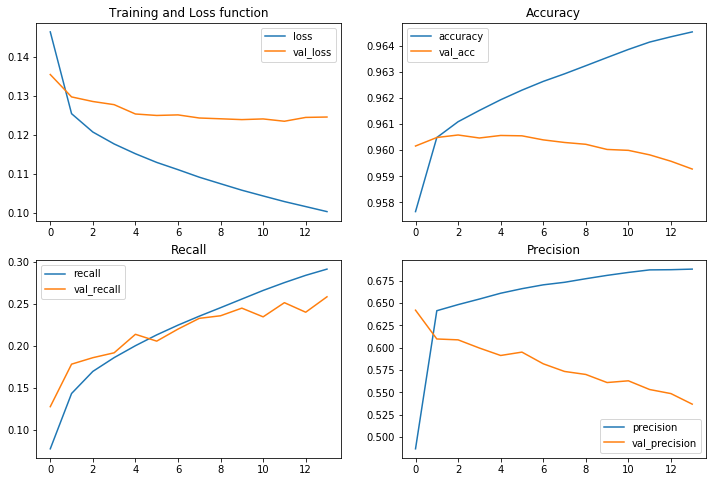

In [9]:
def plot_loss_evaluation(r):
    plt.figure(figsize=(12, 8))

    plt.title('Training and Loss function')
    plt.subplot(2, 2, 1)
    plt.plot(r.history['loss'], label='loss')
    plt.plot(r.history['val_loss'], label='val_loss')
    plt.legend()
    plt.title('Training and Loss function')

    plt.subplot(2, 2, 2)
    plt.plot(r.history['accuracy'], label='accuracy')
    plt.plot(r.history['val_accuracy'], label='val_acc')
    plt.legend()
    plt.title('Accuracy')
    
    plt.subplot(2, 2, 3)
    plt.plot(r.history['recall'], label='recall')
    plt.plot(r.history['val_recall'], label='val_recall')
    plt.legend()
    plt.title('Recall')
    
    plt.subplot(2, 2, 4)
    plt.plot(r.history['precision'], label='precision')
    plt.plot(r.history['val_precision'], label='val_precision')
    plt.legend()
    plt.title('Precision')
    
plot_loss_evaluation(fit)

In [14]:
## final data predictions
model.load_weights('best_model.h5')
final_predictions = model.predict(final_X)

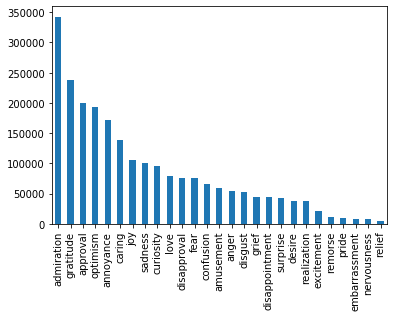

In [15]:
## overall breakdown of emotions in COVID tweets (excluding "neutral")
column_names = list(df.columns[9:]) 
most_probable_emotion = pd.Series([column_names[x] for x in np.argmax(final_predictions, axis=1)])

fig, ax = plt.subplots()
most_probable_emotion.value_counts()[1:].plot(ax=ax, kind='bar')


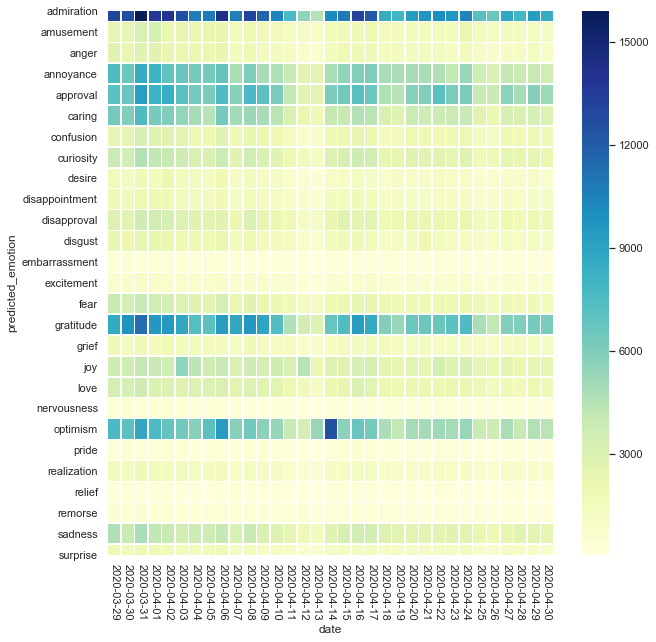

In [17]:
## breakdown of emotions in COVID tweets by date (excluding "neutral")
df_predictions_by_date = pd.DataFrame({"date": final_dates, "predicted_emotion": most_probable_emotion})
df_predictions_by_date = df_predictions_by_date.groupby(["date", "predicted_emotion"]).size().reset_index(name='counts')
df_predictions_by_date = df_predictions_by_date[df_predictions_by_date.predicted_emotion != "neutral"]

pivot = df_predictions_by_date.pivot(index = 'predicted_emotion', columns='date', values='counts')
sns.set()
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(pivot, cmap="YlGnBu", linewidths=0.5)
plt.xticks(rotation=-90)

plt.show()